# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Given the known salary for a big set of Job ID listings along with some known (relevant) features, i.e. Company ID, Job Type, Degree, Major, Industry, Years Experience, and Distance from Metropolitan, we would would like to develop a machine learned statistical model to predict the salary for another dataset of Job ID postings with the same features as the ones for jobs having known salaries. In other words, we train our model based on the Job ID dataset with known salaries and, then, test it on the Job ID dataset with unknown salaries. This is a supervised machine learning problem for lots of applications like glassdoor in order to predict salary for any given Job ID, e.g. position.

In [1]:
# Import the neccessary modules for data manipulation, visual representation, and machine learning algorithms
import numpy as np

import scipy as sp
from scipy.sparse import csr_matrix, hstack
from scipy.stats import *

import pandas as pd
from pandas.plotting import scatter_matrix

#import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

#from sklearn import model_selection
#from sklearn.compose import make_column_selector, ColumnTransformer
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures, LabelBinarizer, Binarizer, StandardScaler, RobustScaler, MinMaxScaler #, OneHotEncoder, LabelEncoder, OrdinalEncoder, 
from sklearn.metrics import make_scorer, r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, mean_squared_error #, mean_absolute_error, 
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso #, LassoLogisticRegression, BayesianRidge, 
from sklearn.tree import DecisionTreeRegressor #, DecisionTreeClassifier, 
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor #, RandomForestClassifier, GradientBoostingClassifier, 
from sklearn.neighbors import KNeighborsRegressor #, KNeighborsClassifier, 
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans

from xgboost import XGBRegressor #, XGBClassifier, 

import seaborn as sns
#import random
#import math
#import time
#import datetime
#import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#your info here
__author__ = "Ashoordin Ashoormaram"
__email__ = "a.ashoormaram@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----
Import the data (make sure you update this on a daily basis if applicable for the corresponding business problem)

In [2]:
#load the data into a Pandas dataframe
#training data
train_features = pd.read_csv('data/train_features.csv')
train_salaries = pd.read_csv('data/train_salaries.csv')

#testing data
test = pd.read_csv('data/test_features.csv')

train_features.head()
train_salaries.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [3]:
train = pd.merge(train_features, train_salaries, on='jobId')
#del train_features, train_salaries
# Examine the dataset
train.tail()
train.info()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999999,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


### ---- 3 Clean the data ----

In [4]:
# Using Kaggle's Code to save time and memory with BIG Datasets
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
# Check to see if there is any missing data in the dataset
train.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [6]:
# Check the type of our features. Are there any data inconsistencies?
train.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [7]:
# look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

#Check to see if there are any missing values in our dataset
train.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [8]:
#Check for duplicate data
train.duplicated().any()

False

In [9]:
#Check for invalid data (salaries <=0)
invalid_salary = sum(n <= 0 for n in train.salary)
print("invalid_salary:", invalid_salary)

#Check for invalid data (milesFromMetropolis <0)
invalid_milesFromMetropolis = sum(n < 0 for n in train.milesFromMetropolis)
print("invalid_milesFromMetropolis:", invalid_milesFromMetropolis)

#Check for invalid data (yearsExperience <0)
invalid_yearsExperience = sum(n < 0 for n in train.yearsExperience)
print("invalid_yearsExperience:", invalid_yearsExperience)

invalid_salary: 5
invalid_milesFromMetropolis: 0
invalid_yearsExperience: 0


In [10]:
#Check those data with 0 values of salaries
#query = 0
train.query('salary == %d' %0)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [11]:
# Get names of indexes for which column salary has value 0
indexNames = train[ train['salary'] == 0 ].index

# Delete these row indexes from dataFrame
train.drop(indexNames, inplace=True)
train.reset_index(drop=True, inplace=True)

print('train shape:', train.shape)
print('\n')
train.tail(5)

train shape: (999995, 9)




,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999990,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


### ---- 4 Explore the data (EDA) ----

summarize each feature variable
summarize the target variable
look for correlation between each feature and the target
look for correlation between features

In [12]:
# Finding count of distinct elements in DataFrame in each feature and target
train.nunique()

jobId                  999995
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    279
dtype: int64

In [13]:
# Showing distinct elements in DataFrame in each feature and target
print('companyId_uniqueValues:\n', train['companyId'].unique())
print('\n')
print('jobType_uniqueValues:\n', train['jobType'].unique())
print('\n')
print('degree_uniqueValues:\n', train['degree'].unique())
print('\n')
print('major_uniqueValues:\n', train['major'].unique())
print('\n')
print('industry_uniqueValues:\n', train['industry'].unique())
print('\n')
print('yearsExperience_uniqueValues:\n', train['yearsExperience'].unique())
print('\n')
print('milesFromMetropolis_uniqueValues:\n', train['milesFromMetropolis'].unique())
print('\n')
print('salary_uniqueValues:\n', train['salary'].unique())

companyId_uniqueValues:
 ['COMP37' 'COMP19' 'COMP52' 'COMP38' 'COMP7' 'COMP15' 'COMP24' 'COMP20'
 'COMP41' 'COMP56' 'COMP4' 'COMP54' 'COMP57' 'COMP14' 'COMP61' 'COMP58'
 'COMP3' 'COMP44' 'COMP30' 'COMP27' 'COMP34' 'COMP11' 'COMP31' 'COMP49'
 'COMP0' 'COMP1' 'COMP36' 'COMP47' 'COMP8' 'COMP42' 'COMP50' 'COMP53'
 'COMP48' 'COMP45' 'COMP46' 'COMP2' 'COMP5' 'COMP55' 'COMP29' 'COMP40'
 'COMP33' 'COMP22' 'COMP12' 'COMP25' 'COMP6' 'COMP23' 'COMP17' 'COMP28'
 'COMP21' 'COMP26' 'COMP43' 'COMP51' 'COMP10' 'COMP59' 'COMP13' 'COMP39'
 'COMP16' 'COMP9' 'COMP32' 'COMP62' 'COMP35' 'COMP18' 'COMP60']


jobType_uniqueValues:
 ['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']


degree_uniqueValues:
 ['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']


major_uniqueValues:
 ['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']


industry_uniqueValues:
 ['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']


yearsExperience_uni

In [14]:
# Summarize statistical description of salary for each feature
train.groupby('companyId')['salary'].describe()
train.groupby('jobType')['salary'].describe()
train.groupby('degree')['salary'].describe()
train.groupby('major')['salary'].describe()
train.groupby('industry')['salary'].describe()
train.groupby('yearsExperience')['salary'].describe()
train.groupby('milesFromMetropolis')['salary'].describe()

,count,mean,std,min,25%,50%,75%,max
companyId,,,,,,,,
COMP0,15666.0,115.963615,38.604597,20.0,89.0,114.0,141.0,285.0
COMP1,15820.0,116.048609,38.424871,20.0,89.0,114.0,141.0,292.0
COMP10,15909.0,116.019800,38.782127,24.0,89.0,114.0,141.0,278.0
COMP11,15872.0,116.113029,38.623401,20.0,88.0,114.0,141.0,286.0
COMP12,15783.0,116.086485,38.697106,20.0,89.0,114.0,141.0,281.0
...,...,...,...,...,...,...,...,...
COMP61,15822.0,116.318607,38.543621,19.0,89.0,114.0,141.0,275.0
COMP62,15943.0,116.279872,39.177694,20.0,88.0,114.0,141.0,286.0
COMP7,15767.0,115.888501,38.549674,20.0,88.0,114.0,141.0,275.0


,count,mean,std,min,25%,50%,75%,max
jobType,,,,,,,,
CEO,124778.0,145.311425,34.423846,55.0,120.0,142.0,167.0,298.0
CFO,124369.0,135.458547,33.069203,51.0,111.0,132.0,156.0,301.0
CTO,125045.0,135.481067,33.090947,51.0,111.0,132.0,156.0,301.0
JANITOR,124971.0,70.813045,24.643021,17.0,52.0,68.0,86.0,189.0
JUNIOR,124592.0,95.333087,29.246759,23.0,74.0,92.0,114.0,248.0
MANAGER,125120.0,115.368518,30.833865,37.0,93.0,112.0,135.0,270.0
SENIOR,125886.0,105.487775,30.069722,31.0,83.0,102.0,124.0,258.0
VICE_PRESIDENT,125234.0,125.368630,31.956295,44.0,102.0,122.0,146.0,272.0


,count,mean,std,min,25%,50%,75%,max
degree,,,,,,,,
BACHELORS,175495.0,125.454663,35.042720,35.0,100.0,122.0,148.0,294.0
DOCTORAL,175362.0,135.490979,35.790555,45.0,109.0,132.0,158.0,301.0
HIGH_SCHOOL,236975.0,101.921085,36.112684,18.0,75.0,99.0,125.0,260.0
MASTERS,175310.0,130.505647,35.399830,38.0,105.0,127.0,153.0,301.0
NONE,236853.0,98.176882,34.915141,17.0,72.0,95.0,121.0,254.0


,count,mean,std,min,25%,50%,75%,max
major,,,,,,,,
BIOLOGY,58379.0,127.932664,34.820141,35.0,103.0,125.0,150.0,285.0
BUSINESS,58518.0,135.648980,37.006526,40.0,109.0,132.0,159.0,294.0
CHEMISTRY,58875.0,129.072085,34.832396,40.0,104.0,126.0,151.0,282.0
COMPSCI,58382.0,132.075605,34.776640,41.0,107.0,129.0,154.0,286.0
ENGINEERING,58594.0,138.441342,38.178934,41.0,111.0,135.0,163.0,301.0
LITERATURE,58684.0,124.423097,33.576413,37.0,100.0,122.0,146.0,271.0
MATH,57800.0,133.322042,35.539246,39.0,107.0,130.0,156.0,280.0
NONE,532353.0,102.583864,36.136268,17.0,76.0,100.0,126.0,270.0
PHYSICS,58410.0,130.372436,34.956981,38.0,105.0,127.0,153.0,293.0


,count,mean,std,min,25%,50%,75%,max
industry,,,,,,,,
AUTO,142941.0,109.435222,36.091590,25.0,84.0,108.0,133.0,264.0
EDUCATION,142819.0,99.448386,35.110257,17.0,75.0,98.0,122.0,253.0
FINANCE,142866.0,130.747659,38.319820,36.0,103.0,128.0,156.0,294.0
HEALTH,142755.0,115.735540,36.865179,28.0,89.0,114.0,140.0,275.0
OIL,142770.0,130.953863,38.528558,37.0,103.0,128.0,156.0,301.0
SERVICE,142639.0,104.446820,35.577606,22.0,79.0,103.0,128.0,256.0
WEB,143205.0,121.645362,38.165659,31.0,94.0,119.0,146.0,290.0


,count,mean,std,min,25%,50%,75%,max
yearsExperience,,,,,,,,
0,39839.0,91.873541,32.383526,17.0,69.0,91.0,113.5,227.0
1,40264.0,93.962373,32.506167,18.0,71.0,93.0,116.0,223.0
2,40045.0,96.125184,32.495476,19.0,73.0,95.0,118.0,229.0
3,40190.0,98.092809,33.026186,21.0,74.0,97.0,120.0,234.0
4,40036.0,100.014112,33.398430,21.0,76.0,99.0,122.0,245.0
5,40013.0,101.681154,33.537491,22.0,78.0,100.0,124.0,245.0
6,40094.0,103.924278,33.708699,21.0,80.0,103.0,127.0,239.0
7,40047.0,106.045022,33.829418,25.0,82.0,105.0,129.0,244.0
8,40118.0,107.838601,34.351790,25.0,83.0,107.0,131.0,248.0


,count,mean,std,min,25%,50%,75%,max
milesFromMetropolis,,,,,,,,
0,10123.0,135.571175,41.096969,29.0,106.0,134.0,163.0,301.0
1,10091.0,135.494203,41.307148,29.0,106.0,133.0,162.0,298.0
2,10031.0,134.930615,41.274564,32.0,105.5,133.0,162.0,292.0
3,10106.0,134.737582,40.662330,31.0,106.0,133.0,162.0,301.0
4,10001.0,134.839916,41.109698,29.0,105.0,133.0,162.0,288.0
...,...,...,...,...,...,...,...,...
95,10125.0,98.025580,32.977865,19.0,74.0,97.0,120.0,226.0
96,10090.0,97.224579,33.063803,18.0,74.0,96.0,119.0,219.0
97,10155.0,97.620876,33.304169,20.0,74.0,96.0,120.0,218.0


In [15]:
#what fraction of data have "NONE" jobId
jobId_none = sum(n=='NONE' for n in train.jobId)
print("jobId_none:", jobId_none)

#what fraction of data have "NONE" companyId
companyId_none = sum(n=='NONE' for n in train.companyId)
print("companyId_none:", companyId_none)

#what fraction of data have "NONE" jobType
jobType_none = sum(n=='NONE' for n in train.jobType)
print("jobType_none:", jobType_none)

#what fraction of data have "NONE" degree
degree_none = sum(n=='NONE' for n in train.degree)
print("degree_none:", degree_none)

#what fraction of data have "NONE" majors
major_none = sum(n=='NONE' for n in train.major)
print("major_none:", major_none)

#what fraction of data have "NONE" industry
industry_none = sum(n=='NONE' for n in train.industry)
print("industry_none:", industry_none)

jobId_none: 0
companyId_none: 0
jobType_none: 0
degree_none: 236853
major_none: 532353
industry_none: 0


yearsExperience            AxesSubplot(0.08,0.125;0.255882x0.755)
milesFromMetropolis    AxesSubplot(0.387059,0.125;0.255882x0.755)
salary                 AxesSubplot(0.694118,0.125;0.255882x0.755)
dtype: object

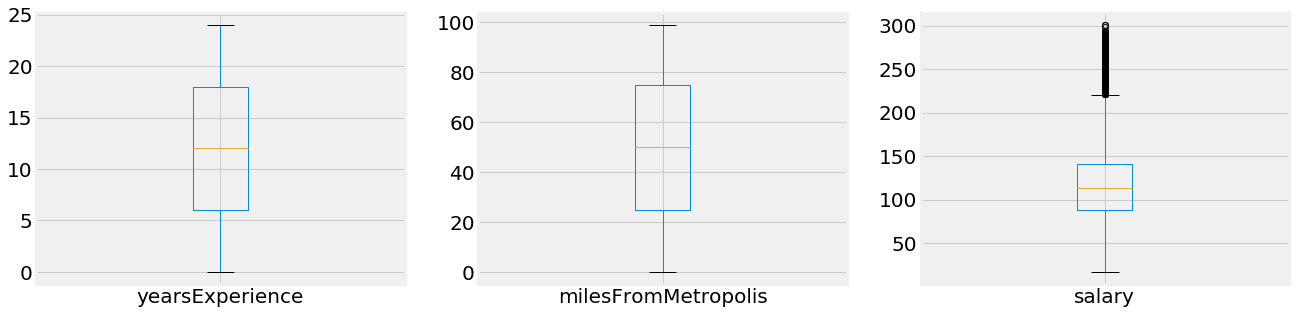

In [16]:
# Box and Whisker Plots of numerical features
train.plot(kind='box', subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(20,5), fontsize=20)
plt.show()

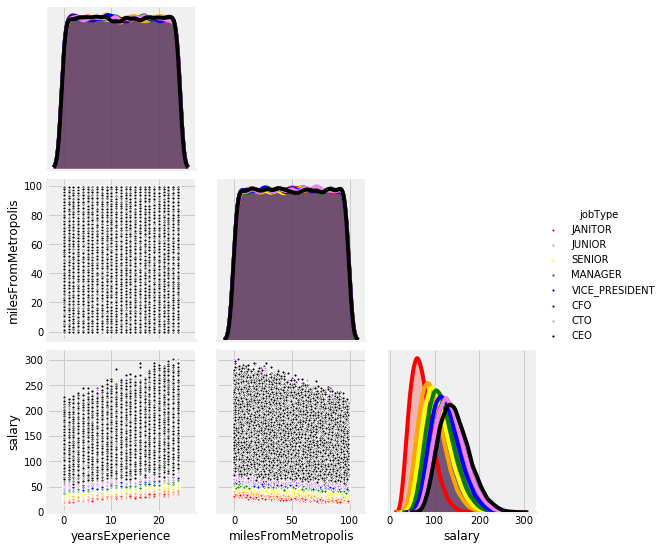

In [17]:
# Now we can get the correlation between the 'salary' and all the other features. 
# Create a correlation matrix. What features correlate the most with salary? What other correlations did you find?
# Make sure to specify some features that you might want to focus on or the plots might be too big
sns.pairplot(train, hue="jobType", 
             hue_order=['JANITOR', 'JUNIOR', 'SENIOR', 'MANAGER', 'VICE_PRESIDENT', 'CFO', 'CTO', 'CEO'],
             palette={'JANITOR':'red', 'JUNIOR':'orange', 'SENIOR':'yellow', 'MANAGER':'green', 'VICE_PRESIDENT':'blue', 'CFO':'indigo', 'CTO':'violet', 'CEO':'black'},
             markers='.', corner=True)

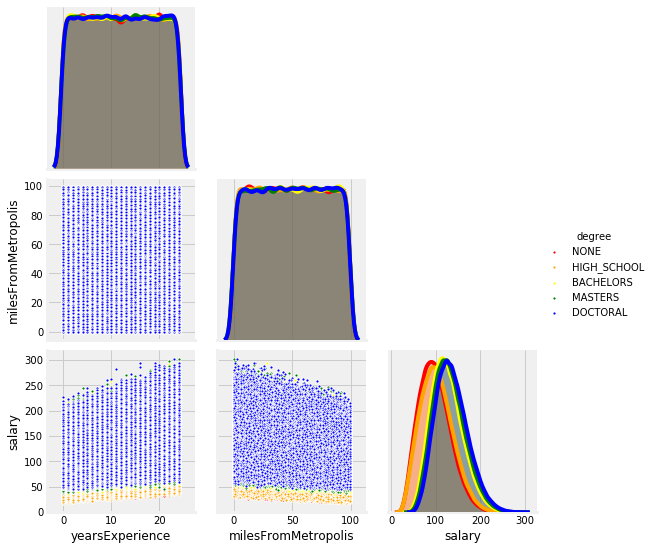

In [18]:
sns.pairplot(train, hue="degree", 
             hue_order=['NONE', 'HIGH_SCHOOL', 'BACHELORS', 'MASTERS', 'DOCTORAL'],
             palette={'NONE':'red', 'HIGH_SCHOOL':'orange', 'BACHELORS':'yellow', 'MASTERS':'green', 'DOCTORAL':'blue'},
             markers='.', corner=True)

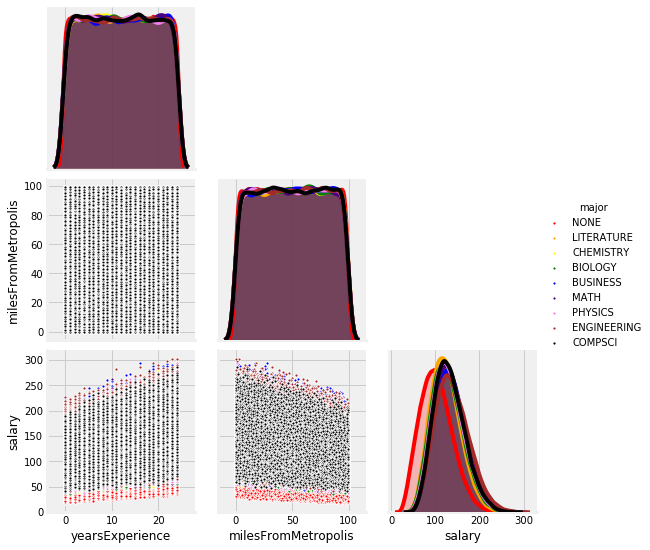

In [19]:
sns.pairplot(train, hue="major", 
             hue_order=['NONE', 'LITERATURE', 'CHEMISTRY', 'BIOLOGY', 'BUSINESS', 'MATH', 'PHYSICS', 'ENGINEERING', 'COMPSCI'],
             palette={'NONE':'red', 'LITERATURE':'orange', 'CHEMISTRY':'yellow', 'BIOLOGY':'green', 'BUSINESS':'blue', 'MATH':'indigo', 'PHYSICS':'violet', 'ENGINEERING':'brown', 'COMPSCI':'black'},
             markers='.', corner=True)

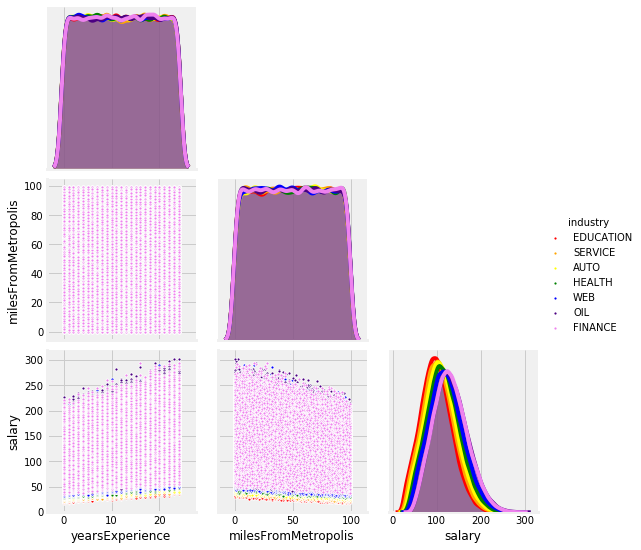

In [20]:
sns.pairplot(train, hue="industry", 
             hue_order=['EDUCATION', 'SERVICE', 'AUTO', 'HEALTH', 'WEB', 'OIL', 'FINANCE'],
             palette={'EDUCATION':'red', 'SERVICE':'orange', 'AUTO':'yellow', 'HEALTH':'green', 'WEB':'blue', 'OIL':'indigo', 'FINANCE':'violet'},
             markers='.', corner=True)

Text(0.5, 1.0, 'companyId')

Text(0.5, 1.0, 'jobType')

Text(0.5, 1.0, 'degree')

Text(0.5, 1.0, 'major')

Text(0.5, 1.0, 'industry')

Text(0.5, 1.0, 'yearsExperience')

Text(0.5, 1.0, 'milesFromMetropolis')

Text(0.5, 1.0, 'salary')

Text(0.5, 1.0, 'salary')

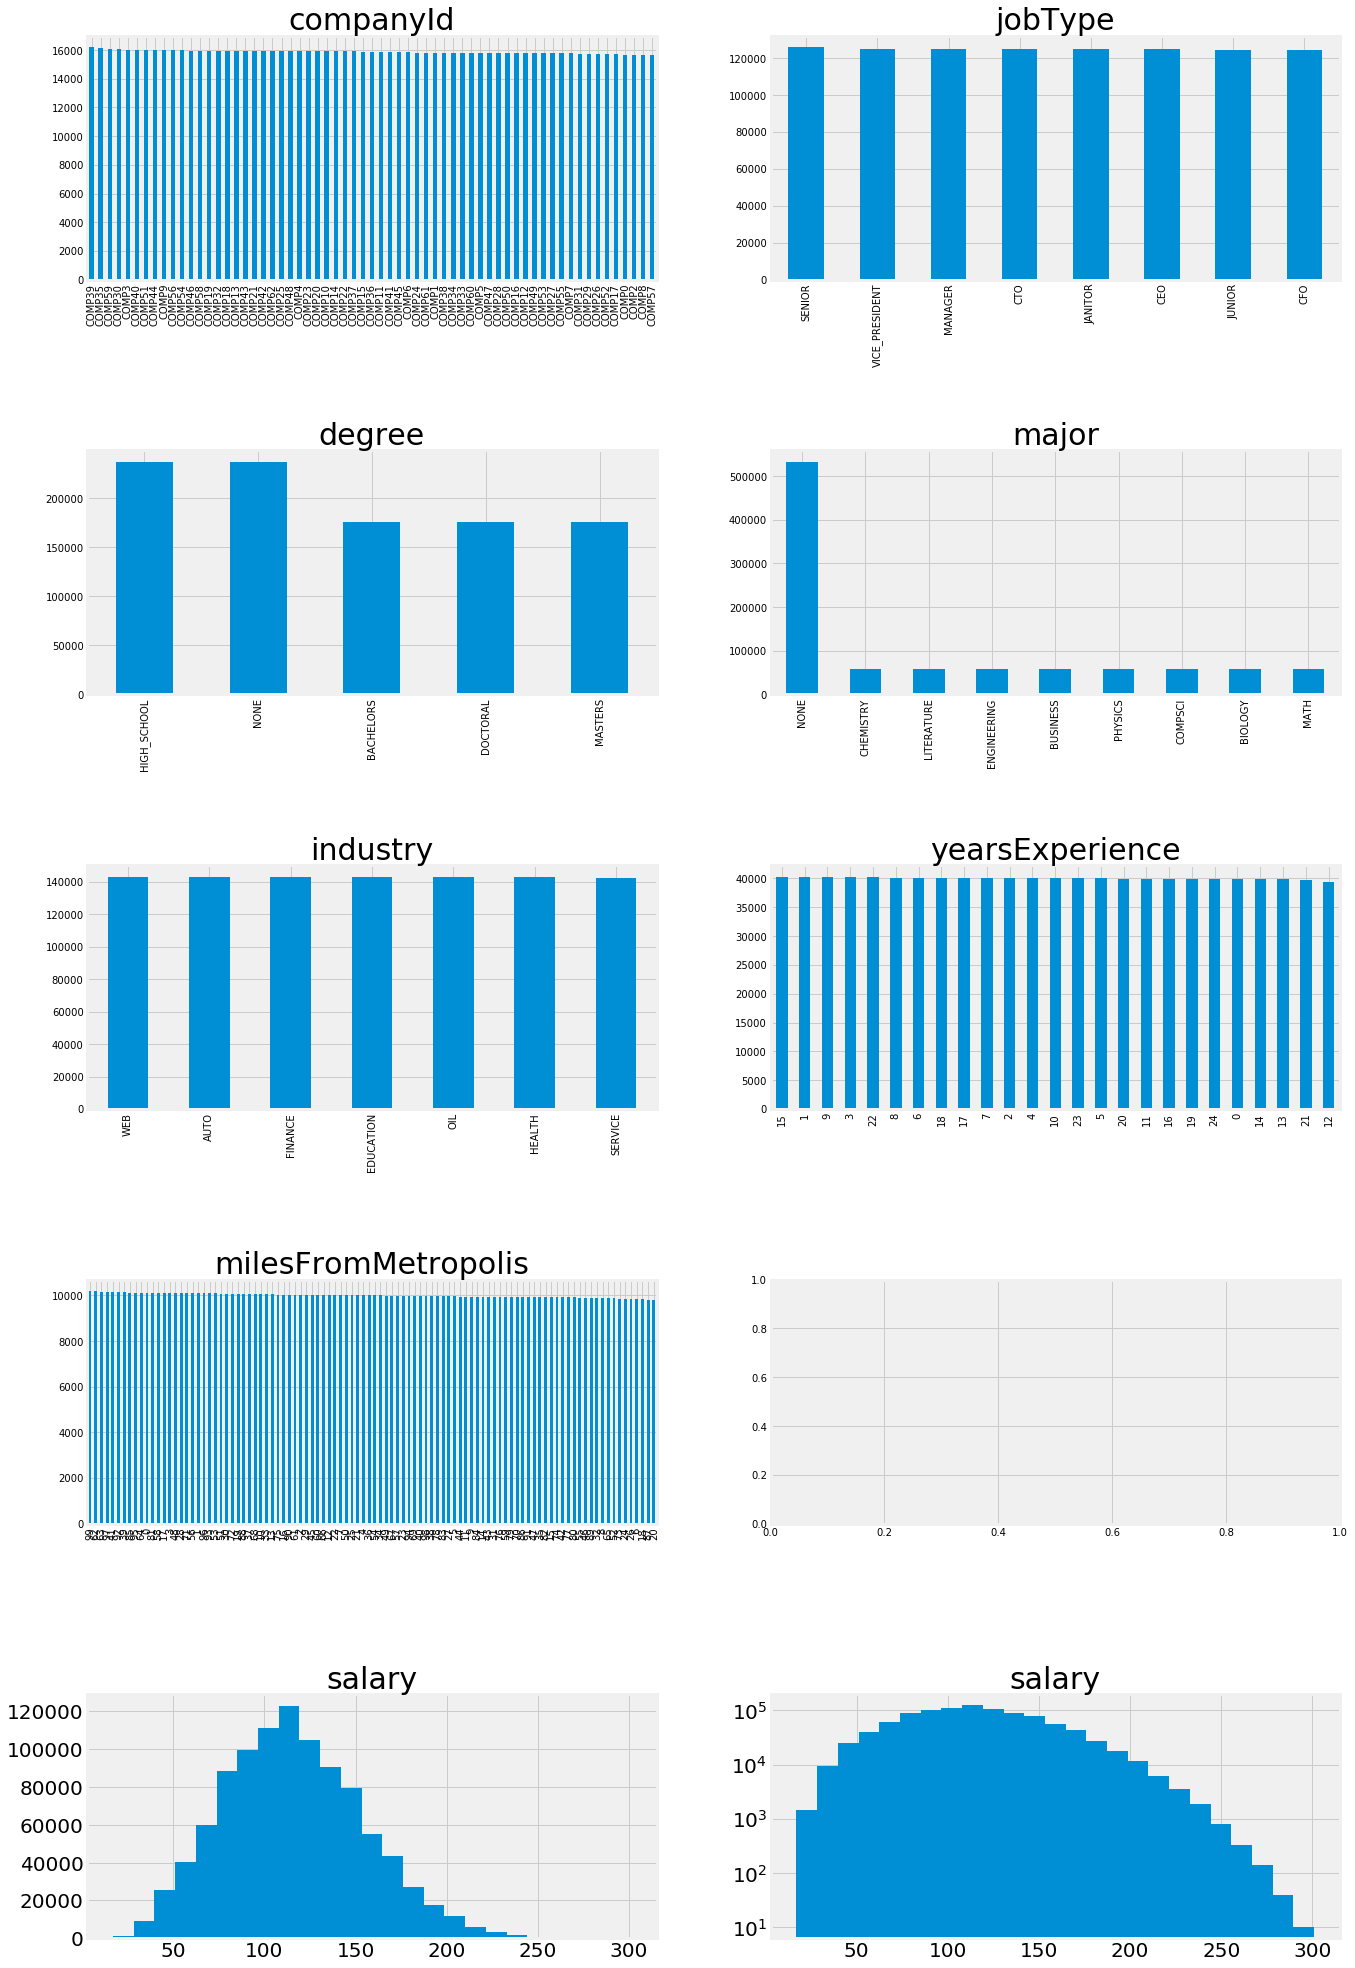

In [21]:
# Histogram Plots of salary
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, sharex=False, sharey=False, figsize=(20,35))

# Bar Plot of companyId
train.companyId.value_counts().plot(ax=ax1, kind='bar', fontsize=10)

# Bar Plot of jobType
train.jobType.value_counts().plot(ax=ax2, kind='bar', fontsize=10)

# Bar Plot of degree
train.degree.value_counts().plot(ax=ax3, kind='bar', fontsize=10)

# Bar Plot of major
train.major.value_counts().plot(ax=ax4, kind='bar', fontsize=10)

# Bar Plot of industry
train.industry.value_counts().plot(ax=ax5, kind='bar', fontsize=10)

# Bar Plot of yearsExperience
train.yearsExperience.value_counts().plot(ax=ax6, kind='bar', fontsize=10)

# Bar Plot of milesFromMetropolis
train.milesFromMetropolis.value_counts().plot(ax=ax7, kind='bar', fontsize=10)

# salary histogram including all features in linear scale
train.salary.hist(ax=ax9, bins=25, xlabelsize=20, ylabelsize=20)

# salary histogram including all features in logarithm scale
train.salary.hist(ax=ax10, bins=25, xlabelsize=20, ylabelsize=20)



ax1.set_title('companyId', fontsize=30)
ax2.set_title('jobType', fontsize=30)
ax3.set_title('degree', fontsize=30)
ax4.set_title('major', fontsize=30)
ax5.set_title('industry', fontsize=30)
ax6.set_title('yearsExperience', fontsize=30)
ax7.set_title('milesFromMetropolis', fontsize=30)
ax9.set_title('salary', fontsize=30)
ax10.set_title('salary', fontsize=30)
ax10.set_yscale('log')

plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

In [22]:
# turn 'objects' into 'categoricals' for train dataset
# ['jobId', companyId', 'jobType', 'degree', 'major', 'industry'] are all categorical features where
# 'degree' and 'jobType' should be encoded as ordinal because of the importance of order while 
# the rest should be encoded as onehot because of its non-ordinal nature
train_data = train.copy()

for col in ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']:
    train_data[col] = train_data[col].astype('category')
train_data.tail()
train_data.dtypes

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999990,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


jobId                  category
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [23]:
# turn 'objects' into 'categoricals' for test dataset
# ['jobId', companyId', 'jobType', 'degree', 'major', 'industry'] are all categorical features where
# 'degree' and 'jobType' should be encoded as ordinal because of the importance of order while 
# the rest should be encoded as onehot because of its non-ordinal nature
test_data = test.copy()

for col in ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']:
    test_data[col] = test_data[col].astype('category')
    
test_data.tail()
test_data.dtypes

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
999995,JOB1362686407682,COMP54,VICE_PRESIDENT,BACHELORS,MATH,OIL,14,3
999996,JOB1362686407683,COMP5,MANAGER,NONE,NONE,HEALTH,20,67
999997,JOB1362686407684,COMP61,JANITOR,NONE,NONE,OIL,1,91
999998,JOB1362686407685,COMP19,CTO,DOCTORAL,MATH,OIL,14,63
999999,JOB1362686407686,COMP34,JUNIOR,NONE,NONE,OIL,16,31


jobId                  category
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
dtype: object

In [24]:
#Convert categorical data to numerical values either through onehot encoding or label encoding for train dataset

train_data = train_data.drop(train_data.columns[0], axis='columns')
test_data = test_data.drop(test_data.columns[0], axis='columns')

train_data_NonEngineered = train_data.copy()

# replace oridinal categorical features in place
replace_map = {'degree': {'NONE': 1, 'HIGH_SCHOOL': 2, 'BACHELORS': 3, 'MASTERS': 4, 'DOCTORAL': 5}, 
               'jobType': {'JANITOR':1, 'JUNIOR':2, 'SENIOR':3, 'MANAGER':4, 'VICE_PRESIDENT':5, 'CFO':6, 'CTO':7, 'CEO':8}
              }
train_data_NonEngineered.replace(replace_map, inplace=True)


#train_data_NonEngineered = train_data_NonEngineered.copy()
# generate binary values using get_dummies to onehot encode the non-ordinal categorical features
train_data_Engineered = pd.get_dummies(train_data_NonEngineered)   #, columns=['companyId', 'major', 'industry'], prefix=["companyId", "major", "industry"]



# merge with main train_data_engineered dum_df on key values
#train_data_Engineered = pd.merge(train_data_NonEngineered, dum_df, on=['jobId', 'jobType', 'degree', 'yearsExperience', 'milesFromMetropolis', 'salary'], how='right').drop(columns=['companyId', 'major', 'industry'])

#taking salary "target" to the end of table
columnsName = list(train_data_Engineered.columns)
salary, last = columnsName.index('salary'), columnsName.index(columnsName[-1])
columnsName[salary], columnsName[last] = columnsName[last],columnsName[salary]
train_data_Engineered = train_data_Engineered[columnsName]

train_data_Engineered = reduce_mem_usage(train_data_Engineered)
print('engineered dataset shape:\n', train_data_Engineered.shape)
print('\n')
train_data_Engineered.info()
print('\n')
train_data_Engineered.tail()

engineered dataset shape:
 (999995, 84)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999995 entries, 0 to 999994
Data columns (total 84 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   jobType              999995 non-null  int8   
 1   degree               999995 non-null  int8   
 2   yearsExperience      999995 non-null  int8   
 3   milesFromMetropolis  999995 non-null  int8   
 4   industry_WEB         999995 non-null  float16
 5   companyId_COMP0      999995 non-null  float16
 6   companyId_COMP1      999995 non-null  float16
 7   companyId_COMP10     999995 non-null  float16
 8   companyId_COMP11     999995 non-null  float16
 9   companyId_COMP12     999995 non-null  float16
 10  companyId_COMP13     999995 non-null  float16
 11  companyId_COMP14     999995 non-null  float16
 12  companyId_COMP15     999995 non-null  float16
 13  companyId_COMP16     999995 non-null  float16
 14  companyId_COMP17     99999

,jobType,degree,yearsExperience,milesFromMetropolis,industry_WEB,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,salary
999990,5,3,19,94,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,88
999991,7,2,12,35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,160
999992,2,2,16,81,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,64
999993,6,4,6,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,149
999994,2,3,20,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,88


In [25]:
#Convert categorical data to numerical values either through onehot encoding or label encoding for test dataset

test_data_NonEngineered = test_data.copy()
test_data_NonEngineered.replace(replace_map, inplace=True)

test_data_NonEngineered = test_data_NonEngineered.copy()
# generate binary values using get_dummies to onehot encode the non-ordinal categorical features
test_data_Engineered = pd.get_dummies(test_data_NonEngineered)  #, columns=['companyId', 'major', 'industry'], prefix=["companyId", "major", "industry"]

# merge with main train_data_engineered dum_df on key values
#test_data_Engineered = pd.merge(test_data_NonEngineered, dum_df_2, on=['jobId', 'jobType', 'degree', 'yearsExperience', 'milesFromMetropolis'], how='right').drop(columns=['companyId', 'major', 'industry'])

test_data_Engineered = reduce_mem_usage(test_data_Engineered)

print('engineered dataset shape:\n', test_data_Engineered.shape)
print('\n')
test_data_Engineered.info()
print('\n')
test_data_Engineered.tail()

engineered dataset shape:
 (1000000, 83)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 83 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   jobType              1000000 non-null  int8   
 1   degree               1000000 non-null  int8   
 2   yearsExperience      1000000 non-null  int8   
 3   milesFromMetropolis  1000000 non-null  int8   
 4   companyId_COMP0      1000000 non-null  float16
 5   companyId_COMP1      1000000 non-null  float16
 6   companyId_COMP10     1000000 non-null  float16
 7   companyId_COMP11     1000000 non-null  float16
 8   companyId_COMP12     1000000 non-null  float16
 9   companyId_COMP13     1000000 non-null  float16
 10  companyId_COMP14     1000000 non-null  float16
 11  companyId_COMP15     1000000 non-null  float16
 12  companyId_COMP16     1000000 non-null  float16
 13  companyId_COMP17     1000000 non-null  float16
 14  companyI

,jobType,degree,yearsExperience,milesFromMetropolis,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
999995,5,3,14,3,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
999996,4,1,20,67,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
999997,1,1,1,91,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
999998,7,5,14,63,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
999999,2,1,16,31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Text(0.5, 1, 'Heatmap of Correlation Matrix')

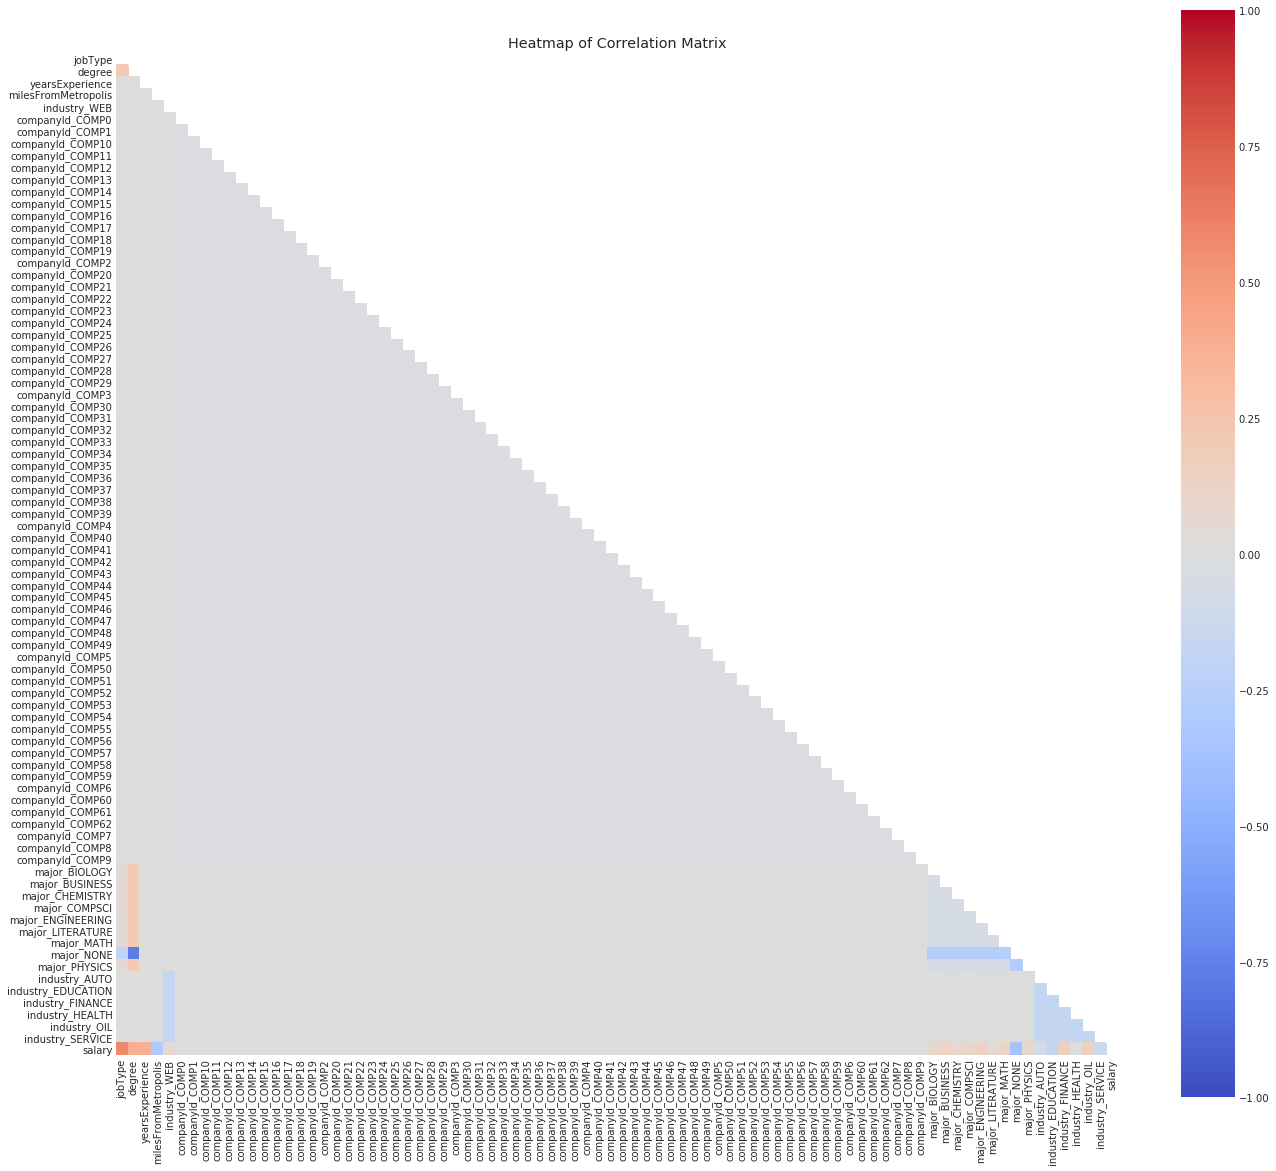

In [26]:
train_data_Engineered_num = train_data_Engineered.select_dtypes(include=np.number)

# Create a correlation matrix. What features correlate the most with salary? What other correlations did you find?
corr_Engineered_num = train_data_Engineered_num.corr()
mask = np.zeros_like(corr_Engineered_num)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(corr_Engineered_num, 
            xticklabels=corr_Engineered_num.columns.values, 
            yticklabels=corr_Engineered_num.columns.values,
            vmin=-1, vmax=1, center= 0, square=True, cmap= 'coolwarm', 
            #annot = True, mask=matrix, cbar_kws= {'orientation': 'horizontal'},
            mask=mask
                    )
    ax.set_title('Heatmap of Correlation Matrix')

"CompanyId" feature hardly ever matters (from the scatter matrix above), so we I make a final engineered version of train and test data to make the model simple. I would then avoid implementing the average salary per "industry" to make the model more robust and apply the same algorithms mentioned above on these train and test data and check for MSE measure of accuracy.

### ---- 5 Establish a baseline ----

In [27]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999995 entries, 0 to 999994
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   companyId            999995 non-null  category
 1   jobType              999995 non-null  category
 2   degree               999995 non-null  category
 3   major                999995 non-null  category
 4   industry             999995 non-null  category
 5   yearsExperience      999995 non-null  int64   
 6   milesFromMetropolis  999995 non-null  int64   
 7   salary               999995 non-null  int64   
dtypes: category(5), int64(3)
memory usage: 27.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   companyId            1000000 non-null  category
 1   jobType              1000000 non-null  cate

In [28]:
train_data = train_data.drop(train_data.columns[0], axis='columns')
test_data = test_data.drop(test_data.columns[0], axis='columns')

# Train Dataset

train_data_NonEngineered_reduced = train_data.copy()
train_data_NonEngineered_reduced.replace(replace_map, inplace=True)

#train_data_NonEngineered_reduced = train_data_NonEngineered_reduced.copy()
train_data_Engineered_reduced = pd.get_dummies(train_data_NonEngineered_reduced)  #, columns=['major', 'industry'], prefix=["major", "industry"]

#train_data_Engineered_reduced = pd.merge(train_data_NonEngineered_reduced) #, dum_df_reduced, on=['jobId', 'jobType', 'degree', 'yearsExperience', 'milesFromMetropolis', 'salary'], how='right').drop(columns=['major', 'industry'])

columnsName_reduced = list(train_data_Engineered_reduced.columns)
salary_reduced, last_reduced = columnsName_reduced.index('salary'), columnsName_reduced.index(columnsName_reduced[-1])
columnsName_reduced[salary_reduced], columnsName_reduced[last_reduced] = columnsName_reduced[last_reduced],columnsName_reduced[salary_reduced]
train_data_Engineered_reduced = train_data_Engineered_reduced[columnsName_reduced]



# Test Dataset
test_data_NonEngineered_reduced = test_data.copy()
test_data_NonEngineered_reduced.replace(replace_map, inplace=True)

#test_data_NonEngineered_reduced = test_data_NonEngineered_reduced.copy()
test_data_Engineered_reduced = pd.get_dummies(test_data_NonEngineered_reduced)  #, columns=['major', 'industry'], prefix=["major", "industry"]

#test_data_Engineered_reduced = pd.merge(test_data_NonEngineered_reduced, dum_df_2_reduced, on=['jobId', 'jobType', 'degree', 'yearsExperience', 'milesFromMetropolis'], how='right').drop(columns=['major', 'industry'])

In [29]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999995 entries, 0 to 999994
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   jobType              999995 non-null  category
 1   degree               999995 non-null  category
 2   major                999995 non-null  category
 3   industry             999995 non-null  category
 4   yearsExperience      999995 non-null  int64   
 5   milesFromMetropolis  999995 non-null  int64   
 6   salary               999995 non-null  int64   
dtypes: category(4), int64(3)
memory usage: 26.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   jobType              1000000 non-null  category
 1   degree               1000000 non-null  category
 2   major                1000000 non-null  cat

In [30]:
### ---- 5 Establish a baseline ----

#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy

train_base = train
# baseline algorithm for regression
def baseline_algorithm_regression(train, test):
    output_values = train['salary'].values
        
    industry = train_base.groupby('industry')['salary'].mean().to_dict()
    for key in industry:
        train_base.loc[train_base.industry == key, "salary"] = int(round(industry[key]))
        
    predicted = train_base['salary'].values
    MSE = mean_squared_error(output_values,predicted)
    return 'True Values={}\nPredicted Values={}\nMean Squared Error={}'.format(output_values, predicted, MSE)
 
print(baseline_algorithm_regression(train_data, test))

True Values=[130 101 137 ...  64 149  88]
Predicted Values=[116 122 116 ...  99 116  99]
Mean Squared Error=1367.244614223071


In [31]:
train_data_Engineered_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999995 entries, 0 to 999994
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   jobType              999995 non-null  int64
 1   degree               999995 non-null  int64
 2   yearsExperience      999995 non-null  int64
 3   milesFromMetropolis  999995 non-null  int64
 4   industry_WEB         999995 non-null  uint8
 5   major_BIOLOGY        999995 non-null  uint8
 6   major_BUSINESS       999995 non-null  uint8
 7   major_CHEMISTRY      999995 non-null  uint8
 8   major_COMPSCI        999995 non-null  uint8
 9   major_ENGINEERING    999995 non-null  uint8
 10  major_LITERATURE     999995 non-null  uint8
 11  major_MATH           999995 non-null  uint8
 12  major_NONE           999995 non-null  uint8
 13  major_PHYSICS        999995 non-null  uint8
 14  industry_AUTO        999995 non-null  uint8
 15  industry_EDUCATION   999995 non-null  uint8
 16  in

In [32]:
train_data_Engineered = reduce_mem_usage(train_data_Engineered_reduced)
test_data_Engineered = reduce_mem_usage(test_data_Engineered_reduced)

train_data_Engineered.info()
test_data_Engineered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999995 entries, 0 to 999994
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   jobType              999995 non-null  int8   
 1   degree               999995 non-null  int8   
 2   yearsExperience      999995 non-null  int8   
 3   milesFromMetropolis  999995 non-null  int8   
 4   industry_WEB         999995 non-null  float16
 5   major_BIOLOGY        999995 non-null  float16
 6   major_BUSINESS       999995 non-null  float16
 7   major_CHEMISTRY      999995 non-null  float16
 8   major_COMPSCI        999995 non-null  float16
 9   major_ENGINEERING    999995 non-null  float16
 10  major_LITERATURE     999995 non-null  float16
 11  major_MATH           999995 non-null  float16
 12  major_NONE           999995 non-null  float16
 13  major_PHYSICS        999995 non-null  float16
 14  industry_AUTO        999995 non-null  float16
 15  industry_EDUCATIO

In [33]:
# Spil-out validation dataset
# Creating the modeled version of the real training data
# workign on the reduced version of dataset wherre "companyId" is removed from both training and testing datasets
data = train_data_Engineered.values
n_features = len(train_data_Engineered.columns)-1
salary_features = data[:,:n_features] 
salary_target = data[:,n_features]
validation_size = 0.20
seed = 7

features_train, features_validation, target_train, target_validation = train_test_split(
    salary_features, salary_target, test_size=validation_size, random_state=seed)

In [34]:
scoring = make_scorer(mean_squared_error)

#shuffle_split = ShuffleSplit(test_size=0.5, train_size=0.5, n_splits=10)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [35]:
# Create model shells  
models = []
models.append(('knr', KNeighborsRegressor()))
models.append(('linreg', LinearRegression()))
models.append(('ridge', Ridge()))
models.append(('lasso', Lasso()))
models.append(('dtr', DecisionTreeRegressor()))
models.append(('gbr', GradientBoostingRegressor()))
models.append(('xgbr', XGBRegressor()))
models.append(('rfr', RandomForestRegressor(n_estimators=10, max_depth=5)))

In [36]:
del train_data, test_data, \
    train_data_Engineered_reduced, test_data_Engineered_reduced, \
    train_base, \
    data, \
    train_features, \
    train, test, \
    train_data_NonEngineered, test_data_NonEngineered

In [37]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:           7793        3422        1851         141        2519        3898
Swap:             0           0           0


In [39]:
results = []
names = []

# Spot test each model with Cross-validation evaluating each model in turn
for name, model in models:
    cv_results = cross_val_score(model, features_train, target_train, cv=kfold, scoring=scoring, n_jobs=-1)  
    #else: 
        #cv_results = cross_val_score(model, features_train, target_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{}: {:.1f} ({:.1f})'.format(name, cv_results.mean(), cv_results.std()))

knr: 450.5 (2.0)
linreg: 394.7 (1.9)
ridge: 394.7 (1.9)
lasso: 447.4 (2.1)
dtr: 695.3 (2.5)
gbr: 368.4 (1.6)
xgbr: 359.2 (1.3)
rfr: 615.1 (4.0)


In [40]:
models = models
results = results
names = names

print('models:\n', models)
print('results:\n', results)
print('names:\n', names)

models:
 [('knr', KNeighborsRegressor()), ('linreg', LinearRegression()), ('ridge', Ridge()), ('lasso', Lasso()), ('dtr', DecisionTreeRegressor()), ('gbr', GradientBoostingRegressor()), ('xgbr', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)), ('rfr', RandomForestRegressor(max_depth=5, n_estimators=10))]
results:
 [array([448.32403564, 449.37130737, 453.11816406, 451.49835205,
       445.94824219, 450.80209351, 451.27438

Text(0.5, 0.98, 'Algorithm Comparison')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f84ae2914d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f84ae291f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f84ae289790>,
 'medians': [<matplotlib.lines.Line2D at 0x7f84ae296990>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f84ae296e90>,
 'means': []}

[Text(0, 0, 'knr'),
 Text(0, 0, 'linreg'),
 Text(0, 0, 'ridge'),
 Text(0, 0, 'lasso'),
 Text(0, 0, 'dtr'),
 Text(0, 0, 'gbr'),
 Text(0, 0, 'xgbr'),
 Text(0, 0, 'rfr')]

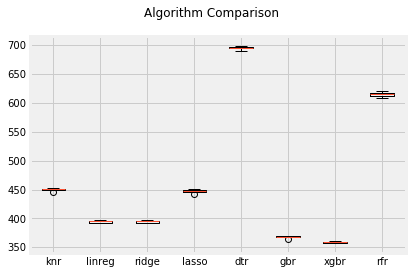

In [41]:
# Graphical comparison of algorithms

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### ---- 6 Hypothesize solution ----

Here, for each algorithm, I first made a prediction on validation dataset and, then, I tuned hyperparameters of each model according to the following procidure: (The three models I chose for the rest of modeling are 'LinearRegression', 'GradientBoostingRegression', and 'XGBoost' given that they seem to produce the least MSE as our metric of the problem).

I can implement a simple grid search just as for loops over the parameters of each model, training and evaluating a regresor for each combination. However, the score could be overly optimistic (or just wrong) since I try many different parameters and select the one with lowest MSE on the test set, but this accuracy won't necessarily carry over to new data; I can use the test data to adjust the parameters as well as to assess how good the model is. One way to resolve this problem is to split the data again, so I have three sets: the training set to build the model, the validation (or development) set to select the parameters of the model, and the test set to evaluate the performance of the selected parameters. This way I can avoid "leaking" of information from the test set into the model. While this method is workable, and relatively commonly used, it is quite sensitive to how exactly the data is split. For a better estimate of the generalization performance, instead of using a single split into training and a validation set, I can use cross-validation to evaluate the performance of each parameter combination. The main downside of the use of cross-validation is the time it takes to train all these models. To solve for this drawback, scikit-learn provides us the GridSearchCV class which implements the methodology in the form of an estimator. To use GridSearchCV class, I first specified the parameters I want to search over using a dictionary. GridSearchCV will then perform all the necessary model fits. It uses cross-validation in place of the split into a training and validation set. However,I still needed to split the data into a training and a test set, to avoid overfitting the parameters.I can call the standard methods fit, predict, and score on the grid_search regressor object I created. Fitting the GridSearchCV object not only searches for the best parameters, but also automatically fits a new model on the whole training dataset with the parameters that yielded the best cross-validation performance.

Here, I am finding the most important features in predicting salaries. I also write down any new features that I think I should try adding to the model based on my EDA, e.g. interaction variables, summary statistics for each group, etc

In [44]:
# Determining
# 1) Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.
# 2) Parameter setting that gave the best results on the hold out data.
# 3) Mean cross-validated score of the best_estimator
# 4) Return the score on the validation data

def randomized_search(model, distributions):
    randomized_search = RandomizedSearchCV(model, distributions, cv=kfold, 
                                           return_train_score=True, n_jobs=-1, scoring=scoring)
    search = randomized_search.fit(features_train, target_train)
    
    print("Best estimator:\n{} \nBest parameters:\n{} \nBest cross-validation score: {:.3f} \nBest test score: {:.3f}\n\n\n".format(
            search.best_estimator_, search.best_params_, search.best_score_, search.score(features_validation, target_validation)
            ))

In [ ]:
distributions_ridge = dict(alpha=uniform(loc=0.1, scale=1.9))
distributions_gbr = dict(learning_rate=uniform(loc=0, scale=0.5), 
                         max_depth=randint(low=2, high=21), 
                         n_estimators=randint(low=10, high=101)
                        )
distributions_xgbr = dict(learning_rate=uniform(loc=0, scale=0.5), 
                          max_depth=randint(low=2, high=21), 
                          n_estimators=randint(low=10, high=101)
                         )

randomized_search(models[2][1], distributions_ridge)
randomized_search(models[5][1], distributions_gbr)
randomized_search(models[6][1], distributions_xgbr)

Best estimator:
Ridge(alpha=0.5812497170879986) 
Best parameters:
{'alpha': 0.5812497170879986} 
Best cross-validation score: 394.660 
Best test score: 393.307





In [ ]:
def plot_feature_importances(model):
    clf = model.fit(features_train, target_train)
    plt.barh(np.arange(n_features), clf.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train_data_Engineered.columns.values[:-1])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.title("{}".format(clf.__class__.__name__))

In [ ]:
# "GradientBoostingRegressor" ('gbr')  , "max_features": [18, 19, 20]
param_grid_gbr = {"max_depth": [5, 6, 7], "max_features": [15, 16, 17, 18, 19, 20]}
grid_search_gbr = GridSearchCV(models[5][1], param_grid_gbr, cv=kfold, return_train_score=True, n_jobs=-1)
grid_search_gbr.fit(features_train, target_train)

# evaluate how well the best found parameters generalize
print("Test set score: {:.3f}".format(grid_search_gbr.score(features_validation, target_validation)))
# determine the model with the best parameters trained on the whole training set
print("Best estimator:\n{}".format(grid_search_gbr.best_estimator_))
# the best cross-validation accuracy (the mean accuracy over the different splits for the best parameter setting)
print("Best cross-validation score: {:.3f}".format(grid_search_gbr.best_score_))

In [ ]:
plot_feature_importances(GradientBoostingRegressor(max_depth=7, max_features=19))

In [ ]:
# "XGBRegressor" ('xgbr')
for booster in ['gbtree', 'gblinear', 'dart']:
    param_grid_xgbr = {"reg_alpha": [0, 1], "reg_lambda": [0, 1], "max_depth": [5, 6, 7], "max_features": [15, 16, 17, 18, 19, 20]}
    grid_search_xgbr = GridSearchCV(models[6][1], param_grid_xgbr, cv=kfold, return_train_score=True, n_jobs=-1)
    grid_search_xgbr.fit(features_train, target_train)

    print("booster = ", booster)
    # evaluate how well the best found parameters generalize
    print("Test set score: {:.3f}".format(grid_search_xgbr.score(features_validation, target_validation)))
    # determine the model with the best parameters trained on the whole training set
    print("Best estimator:\n{}".format(grid_search_xgbr.best_estimator_))
    # the best cross-validation accuracy (the mean accuracy over the different splits for the best parameter setting)
    print("Best cross-validation score: {:.3f}".format(grid_search_xgbr.best_score_))
    print('\n')

In [ ]:
plot_feature_importances(XGBRegressor(grid_search_xgbr.best_estimator_))

In [ ]:
# LinearRegression, ('linreg')
for normalizing_value in [False, True]:
    linreg = models[1][1]
    if normalizing_value == True:
        
        grid_search_linreg = GridSearchCV(linreg(normalize=normalizing_value), cv=kfold, return_train_score=True, n_jobs=-1)
        grid_search_linreg.fit(features_train, target_train)

        print("Normalization = {}: {}".format(normalizing_value, "The regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm"))
        # evaluate how well the best found parameters generalize
        print("Test set score: {:.3f}".format(grid_search_linreg.score(features_validation, target_validation)))
        # determine the model with the best parameters trained on the whole training set
        print("Best estimator:\n{}".format(grid_search_linreg.best_estimator_))
        # the best cross-validation accuracy (the mean accuracy over the different splits for the best parameter setting)
        print("Best cross-validation score: {:.3f}".format(grid_search_linreg.best_score_))
        print('\n')
        
        
    if normalizing_value == False:
        grid_search_linreg = GridSearchCV(linreg(normalize=normalizing_value), cv=kfold, return_train_score=True, n_jobs=-1)
        standard_scalar = StandardScaler()
        standard_scalar.fit(features_train, target_train)
        grid_search_linreg.standard_scalar

        print("Normalization = {}: {}".format("Standard Scaler", "Standardized X before calling fit"))
        # evaluate how well the best found parameters generalize
        print("Test set score: {:.3f}".format(grid_search_linreg.score(features_validation, target_validation)))
        # determine the model with the best parameters trained on the whole training set
        print("Best estimator:\n{}".format(grid_search_linreg.best_estimator_))
        # the best cross-validation accuracy (the mean accuracy over the different splits for the best parameter setting)
        print("Best cross-validation score: {:.3f}".format(grid_search_linreg.best_score_))
        print('\n')

In [ ]:
plot_feature_importances(LinearRegression(grid_search_linreg.best_estimator_))

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data